<a href="https://colab.research.google.com/github/sevendaystoglory/temp/blob/main/gpt_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building a GPT

Companion notebook to the [Zero To Hero](https://karpathy.ai/zero-to-hero.html) video on GPT.

In [1]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-02-08 03:44:20--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2025-02-08 03:44:21 (22.7 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [2]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [3]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [4]:
# let's look at the first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [5]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [8]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype) #rank 1 tensor. its a really long sequence of the data points
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [9]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [12]:
block_size = 8 #the GPT will look at no more text than this at any time
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [152]:
x = train_data[:block_size] #the max window that we want the GPT to train on
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


In [153]:
torch.manual_seed(1337) #so that the randint function always returns the same output form the training/validation dataset
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    #geenrates these batches randomly from either the training data or the val data
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape) #same 4 batches of sequences of 8 tokens offset by +1
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

In [15]:
print(xb) # our input to the transformer

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


https://excalidraw.com/#json=S299k_EM4hRFRHcGLfApb,rsBq7lNRJzWL1seYy0Oxew

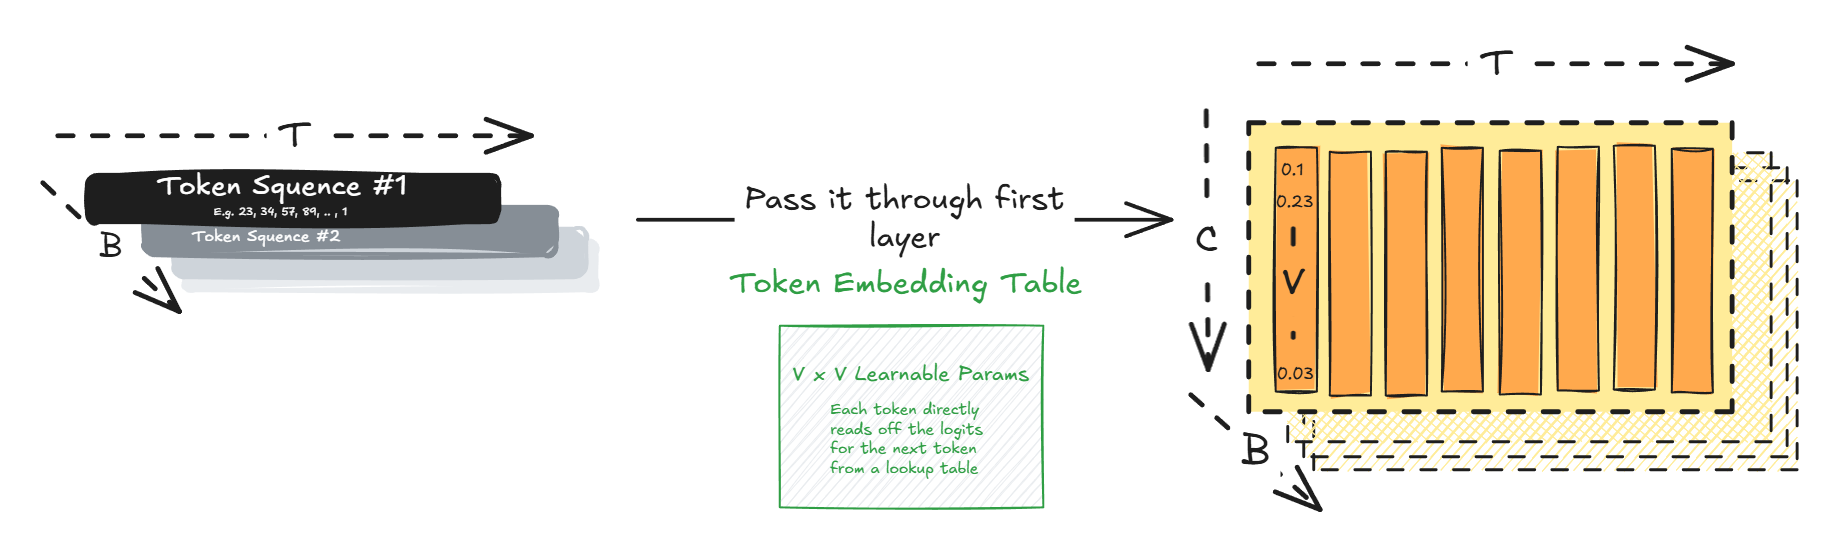

Implements Below

In [154]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size) # implements a 65 x 65 lookup table for the embeddings. It is functionally an embedding layer (as in Torch implementation - it converts integers to dense, continuous vector embeddings). However, the embeddings usually map tokens from one-hot encoded sparse vector to low dimensional dense vector. Here, this layer is just used to lookup the probabilities of the next token.

    def forward(self, idx, targets=None): #forward pass

        # idx and targets are both (B,T) tensor of integers - (4, 8) matrix of integers as seen above
        logits = self.token_embedding_table(idx) # (B,T,C) # Assign to each token in my batch (there are 4 blocks in my batch, each block has 8 tokens) a channel. This is obtained by lookup form the embedding table
        #logits are scores on what comes next. Just from the indivudual identity of the individual token. Right, now the individual identity is characteristed by the number of channels which is 65. (Makes sense as it should be equal to the vocab size, hence the size of our embedding matrix above)


        #Here we evaluate the loss, using cross entropy
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C) # Logically the
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens): #The job of generate is to take a batch and add a token to make to increase its dimension to T+1 as in line **
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C). This gives us 65 channels for one token (). We have fixed the time as a T = max
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # print (probs) # In case you want to see the probability distribution of the tokens. Returns an array of (B, C) i.e. 4 batches
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1). Sample from the distribution.
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1) **
        return idx

model = BigramLanguageModel(vocab_size)
logits, loss = model(xb, yb) # is syntactic sugar for `logits, loss = model.forward(xb, yb)`
print(logits.shape) # for each 4*8 tokens there are 65 channels. These channels are used to predict the next token from the individual token only.
print(loss)
print(logits)

print(decode(model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=10)[0].tolist())) # B, T  = 1, 1 ! Here, increasing time (block size) doesnt matter since we are working with a bigram model and it looks at the last token in the block anyway to generate the next token


torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)
tensor([[-1.5101, -0.0948,  1.0927,  ..., -0.6126, -0.6597,  0.7624],
        [ 0.3323, -0.0872, -0.7470,  ..., -0.6716, -0.9572, -0.9594],
        [ 0.2475, -0.6349, -1.2909,  ...,  1.3064, -0.2256, -1.8305],
        ...,
        [-2.1910, -0.7574,  1.9656,  ..., -0.3580,  0.8585, -0.6161],
        [ 0.5978, -0.0514, -0.0646,  ..., -1.4649, -2.0555,  1.8275],
        [-0.6787,  0.8662, -1.6433,  ...,  2.3671, -0.7775, -0.2586]],
       grad_fn=<ViewBackward0>)

Sr?qP-QWkt


## Training the model

we are learning the 65x65 parameters in the token embedding table.

In [155]:
def forward_hook(module, input, output):
    print(f"Layer: {module.__class__.__name__}")
    print(f"Input: {input}")
    print(f"Output: {output}\n")

hook = model.token_embedding_table.register_forward_hook(forward_hook)

# Run a forward pass to see values
logits, loss = model(xb, yb)

# Remove the hook after use
hook.remove()

Layer: Embedding
Input: (tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]]),)
Output: tensor([[[-1.5101, -0.0948,  1.0927,  ..., -0.6126, -0.6597,  0.7624],
         [ 0.3323, -0.0872, -0.7470,  ..., -0.6716, -0.9572, -0.9594],
         [ 0.2475, -0.6349, -1.2909,  ...,  1.3064, -0.2256, -1.8305],
         ...,
         [ 0.5978, -0.0514, -0.0646,  ..., -1.4649, -2.0555,  1.8275],
         [ 1.0901,  0.2170, -2.9996,  ..., -0.5472, -0.8017,  0.7761],
         [ 0.3323, -0.0872, -0.7470,  ..., -0.6716, -0.9572, -0.9594]],

        [[ 1.0541,  1.5018, -0.5266,  ...,  1.8574,  1.5249,  1.3035],
         [-0.1324, -0.5489,  0.1024,  ..., -0.8599, -1.6050, -0.6985],
         [-0.6722,  0.2322, -0.1632,  ...,  0.1390,  0.7560,  0.4296],
         ...,
         [ 1.0901,  0.2170, -2.9996,  ..., -0.5472, -0.8017,  0.7761],
         [ 1.1513,  1.0539,  3.4105,  ..., -0.5686,  0.9

In [156]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [157]:
batch_size = 32
for steps in range(10000): # increase number of steps for good results...
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward() #pytorch has automatic differentiation engine 'Autograd' which will compute the loss. Pytorch will traverse the computational graph created during the forward pass.
    optimizer.step()

print(loss.item())


2.4730143547058105


In [158]:
print(decode(model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


By y a!
Caril.n y, denjxhece w illd CHAL, mer thoun s's:Conchuntilalllevise sthat dy hangilyoteng h hasbe pave pirance
Rie hicomyonthar's
Plinseard ith henoure wounonthioneir thondy, y heltieiengerofo'dsssit ey
KIN d pe wither vouprrouthercc.
hathe; d!
My hind tt hinig t ouchos tes; st yo hind wotte grotonear 'so it t jod weancotha:
h hay.JUCle n prids, r loncave w hollular s O:
HIs; ht anjx?

DUThinqunt.

LaZAnde.
athave l.
KEONH:
ARThanco be y,-hedarwnoddy scace, tridesar, wnl'shenous s ls, th


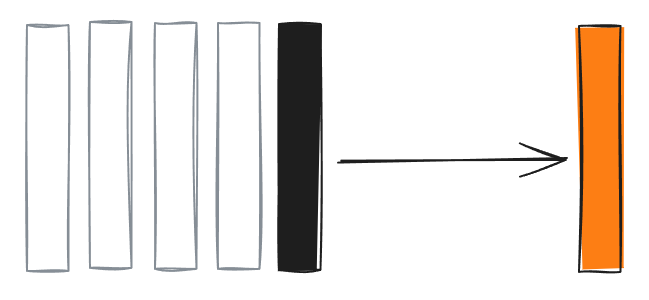

## The mathematical trick in self-attention

This is a step to help us go from a bigram-style model (where tokens have no interaction) to a naive contextual model (where each token representation is enriched by averaging embeddings of past tokens). This is not the most sophisticated architecture, but it is a good incremental step.

Problem: There is no “intermediate” embedding space that can be manipulated or combined with the embeddings of other tokens (e.g., by averaging, or computing attention).

Goal: Introduce a learnable embedding dimension 'D'

D that is smaller (or at least distinct) from vocab_size. Then each token index gets mapped to a D-dimensional feature vector.

Though we have not implemented this layer here. What we have done is average out the channels that are an output of that layer.


In [159]:
# consider the following toy example:

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels -- these channels are an output of our dense embedding layer
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [160]:
# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C)) #bow -> bag of words
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)

print(x[0]) #you can see how we encode the context of token at time T as average of all the tokens uptil that points. Note: Since tokens are just ids, we are averaging the channel representation of the token.


tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])


In [162]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)
print(x)
print(xbow2[0])
# torch.allclose(xbow, xbow2)

tensor([[[ 0.1808, -0.0700],
         [-0.3596, -0.9152],
         [ 0.6258,  0.0255],
         [ 0.9545,  0.0643],
         [ 0.3612,  1.1679],
         [-1.3499, -0.5102],
         [ 0.2360, -0.2398],
         [-0.9211,  1.5433]],

        [[ 1.3488, -0.1396],
         [ 0.2858,  0.9651],
         [-2.0371,  0.4931],
         [ 1.4870,  0.5910],
         [ 0.1260, -1.5627],
         [-1.1601, -0.3348],
         [ 0.4478, -0.8016],
         [ 1.5236,  2.5086]],

        [[-0.6631, -0.2513],
         [ 1.0101,  0.1215],
         [ 0.1584,  1.1340],
         [-1.1539, -0.2984],
         [-0.5075, -0.9239],
         [ 0.5467, -1.4948],
         [-1.2057,  0.5718],
         [-0.5974, -0.6937]],

        [[ 1.6455, -0.8030],
         [ 1.3514, -0.2759],
         [-1.5108,  2.1048],
         [ 2.7630, -1.7465],
         [ 1.4516, -1.5103],
         [ 0.8212, -0.2115],
         [ 0.7789,  1.5333],
         [ 1.6097, -0.4032]]])
tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        

In [116]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)


False

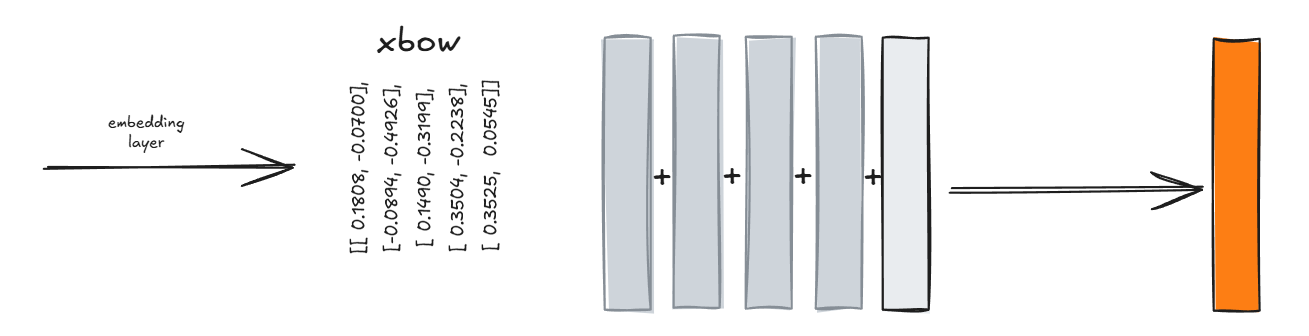

The tokens are communicating now! But the information loss is immense as we are only taking the averages of their token_embeddings

We don't want the matrix multiplication to be a simple uniform average. The token might find some of the past tokens more interesting. Hence, we want the multiplication to be data dependent. How? This is the problem that self-attention solves.

### How is this achieved?
Each token emits two vectors - a key(K), and a query(Q). The key has information - "What do I contain?". The query asks a question - "What information am I looking for?"

The weight matrix weight value for that token(T1) w.r.t another token(T2) then becomes dot product of Q1 and K2.

In [128]:
# version 4: The following is a self-attention head!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16 # is a self-attention hyperparam

# the key, query and value layers are initialised
key = nn.Linear(C, head_size, bias=False) #"here's what i have"
query = nn.Linear(C, head_size, bias=False) #"here's what i'm looking for"
value = nn.Linear(C, head_size, bias=False) #"here's what will be aggregated (not key) if you find me interesting"

# all tokens produce key and queries independently. Each are of 16 dimensions.
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
# Now the communication happens. They dot product!
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v
#out = wei @ x

out.shape

torch.Size([4, 8, 16])

In [127]:
wei[0]

tensor([1., 0., 0., 0., 0., 0., 0., 0.])

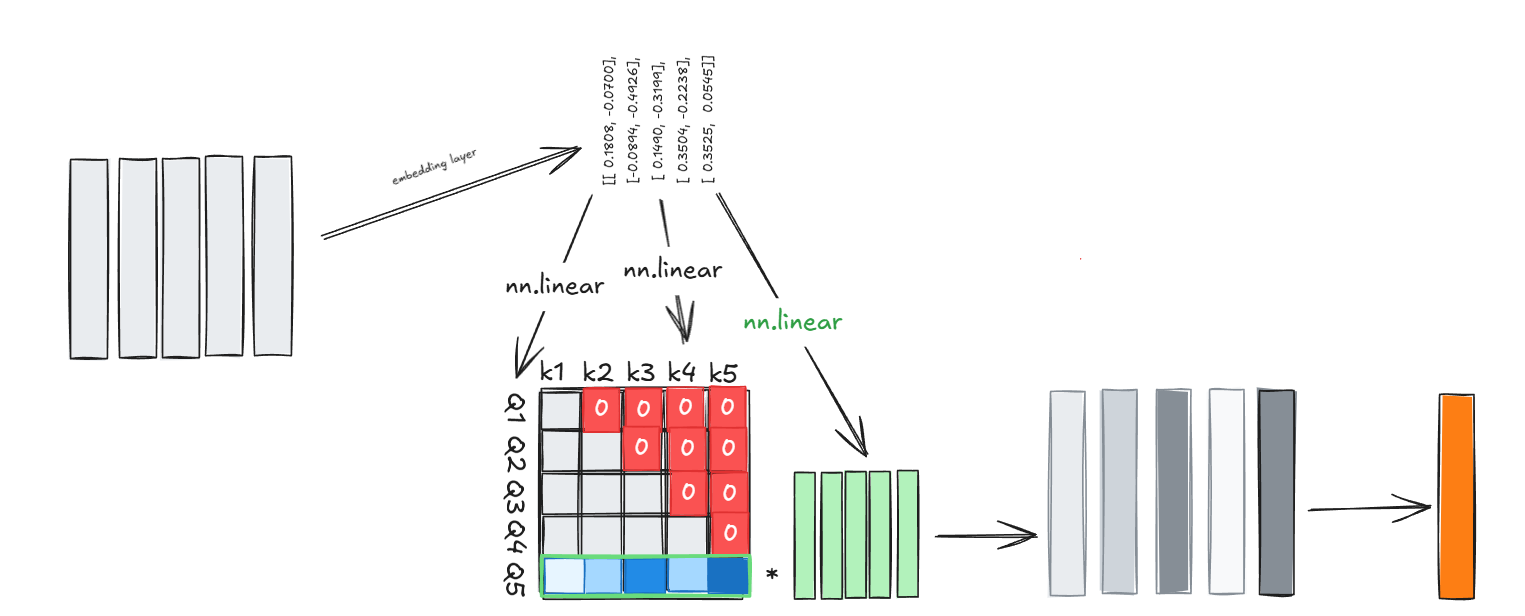

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

In [129]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

In [132]:
k.var()

tensor(1.0449)

In [133]:
q.var()

tensor(1.0700)

In [134]:
wei.var()

tensor(1.0918)

In [135]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [136]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

In [ ]:
class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [ ]:
x[:,0].mean(), x[:,0].std() # mean,std of one feature across all batch inputs

(tensor(0.1469), tensor(0.8803))

In [ ]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features

(tensor(-9.5367e-09), tensor(1.0000))

In [ ]:
# French to English translation example:

# <--------- ENCODE ------------------><--------------- DECODE ----------------->
# les réseaux de neurones sont géniaux! <START> neural networks are awesome!<END>



### Full finished code, for reference

You may want to refer directly to the git repo instead though.

In [163]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# This class is named as bigram language model but its not a bigram language model anymore! Its a language model. Architecture is transformer. Its autoregressive.
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


0.209729 M parameters
step 0: train loss 4.4116, val loss 4.4022
step 100: train loss 2.6568, val loss 2.6670
step 200: train loss 2.5090, val loss 2.5059
step 300: train loss 2.4196, val loss 2.4338
step 400: train loss 2.3504, val loss 2.3566
step 500: train loss 2.2965, val loss 2.3129
step 600: train loss 2.2410, val loss 2.2500
step 700: train loss 2.2057, val loss 2.2191
step 800: train loss 2.1633, val loss 2.1864
step 900: train loss 2.1244, val loss 2.1510
step 1000: train loss 2.1038, val loss 2.1308
step 1100: train loss 2.0707, val loss 2.1197
step 1200: train loss 2.0377, val loss 2.0800
step 1300: train loss 2.0268, val loss 2.0650
step 1400: train loss 1.9918, val loss 2.0356
step 1500: train loss 1.9697, val loss 2.0293
step 1600: train loss 1.9645, val loss 2.0499
step 1700: train loss 1.9404, val loss 2.0129
step 1800: train loss 1.9095, val loss 1.9951
step 1900: train loss 1.9067, val loss 1.9855
step 2000: train loss 1.8854, val loss 1.9948
step 2100: train loss 1.